<a href="https://colab.research.google.com/github/alexander-toschev/ai-tools/blob/main/fakeml/Practise_FakeAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 🎙️ Colab-практика: Определение фейкового аудио на реальном датасете (Fake-or-Real Audio)

# 0. Скачивание и установка библиотек
!pip install librosa scikit-learn tensorflow matplotlib



--2025-04-28 12:17:18--  https://zenodo.org/record/5019386/files/fake_or_real_audio.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5019386/files/fake_or_real_audio.zip [following]
--2025-04-28 12:17:19--  https://zenodo.org/records/5019386/files/fake_or_real_audio.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 404 NOT FOUND
2025-04-28 12:17:19 ERROR 404: NOT FOUND.

[fake_or_real_audio.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of fake_or_real_audio.zip or
        fake_or_real_audio

In [5]:
# Скачиваем датасет
#!wget https://datashare.ed.ac.uk/bitstream/handle/10283/3336/LA.zip?sequence=3&isAllowed=y -O fake_or_real_audio.zip

/bin/bash: line 1: -O: command not found
--2025-04-28 12:21:20--  https://datashare.ed.ac.uk/bitstream/handle/10283/3336/LA.zip?sequence=3
Resolving datashare.ed.ac.uk (datashare.ed.ac.uk)... 129.215.67.172
Connecting to datashare.ed.ac.uk (datashare.ed.ac.uk)|129.215.67.172|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 7640952520 (7.1G) [application/zip]
Saving to: ‘LA.zip?sequence=3’

LA.zip?sequence=3    45%[========>           ]   3.25G  10.9MB/s    eta 10m 42s

KeyboardInterrupt: 

In [7]:
!gdown https://drive.google.com/uc?id=1eWbJpNrz_-N3QP5fDTFg329N2Fog4Ngk -O audio.zip

Downloading...
From: https://drive.google.com/uc?id=1eWbJpNrz_-N3QP5fDTFg329N2Fog4Ngk
To: /content/audio.zip
100% 10.8M/10.8M [00:00<00:00, 133MB/s]


In [8]:
!unzip -q audio.zip -d /content/audio

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.3395 - loss: 2.0606 - val_accuracy: 0.6000 - val_loss: 47.4313
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7598 - loss: 34.5468 - val_accuracy: 0.6000 - val_loss: 30.3620
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7806 - loss: 19.1028 - val_accuracy: 0.6000 - val_loss: 8.5582
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7598 - loss: 7.3220 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9608 - loss: 0.1020 - val_accuracy: 0.6000 - val_loss: 2.3988
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4596 - loss: 1.8856 - val_accuracy: 1.0000 - val_loss: 0.0788
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8799 - loss: 0.1816 - val_accuracy: 1.0000 - val_loss: 0.0704
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0224 - val_accuracy: 0.8000 - val_loss

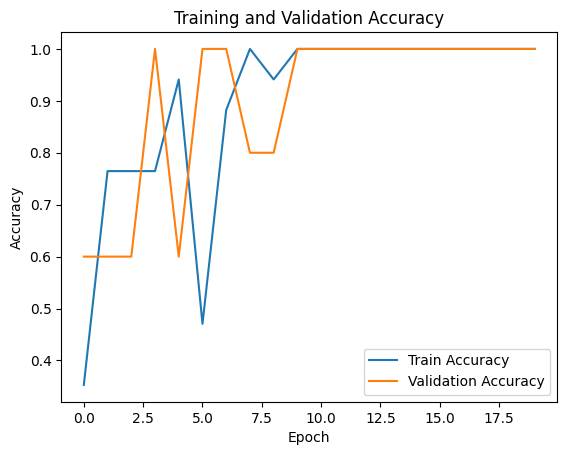

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Prediction (1 = fake, 0 = real): 1
Label
fake    16
real     6
Name: count, dtype: int64


In [10]:


# 1. Импорты
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import os

# 2. Подготовка данных
REAL_DIR = '/content/audio/audio/real'
FAKE_DIR = '/content/audio/audio/fake'

# Функция загрузки и извлечения MFCC признаков

def extract_features(file_path, max_pad_len=100):
    try:
        audio, sample_rate = librosa.load(file_path)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc
    except Exception as e:
        print("Error encountered while parsing file: ", file_path)
        return None

# Загрузка всех данных
features = []
labels = []

for dirpath, label in [(REAL_DIR, 'real'), (FAKE_DIR, 'fake')]:
    for file in os.listdir(dirpath):
        if file.endswith('.wav'):
            data = extract_features(os.path.join(dirpath, file))
            if data is not None:
                features.append(data)
                labels.append(label)

# Преобразуем в массивы
X = np.array(features)
y = np.array(labels)

# Преобразуем метки
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Добавляем ось канала для Conv2D
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# 3. Построение модели
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(40, 100, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Обучение модели
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# 5. Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")

# 6. Визуализация обучения
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# 7. Прогноз для одного примера
sample_idx = 0
sample = np.expand_dims(X_test[sample_idx], axis=0)
pred = model.predict(sample)
print("Prediction (1 = fake, 0 = real):", round(pred[0][0]))

# 8. Баланс классов
import pandas as pd
labels_df = pd.DataFrame(labels, columns=['Label'])
print(labels_df['Label'].value_counts())
